# **Part 1: Data Preprocessing, Feature Engineering, and Visualization**

## **Objective**

- Analyze and preprocess cricket match data containing **17,844 records** to extract meaningful insights.
- Create **team** and **player-level features** to capture the performance trends over time.
- Provide **visualizations** to explore critical patterns in the data.
- Create features related to match data, focusing on opponent strength, team strength, and time factors.
- Calculate player values yearly, and update stats after each match in production.

---
# Section 1

## **Functions Overview**

### **1. Player Value Calculation  ***
This function calculates the value of individual players.

- **Metrics Considered**:
  - **Player of the Match**: Acknowledges a player's impact.
  - **Total Runs Scored per Match**: Assesses batting performance.
 
  - **Dot Balls as Bowler per Match**: Measures bowling efficiency.
 
  - **Experience**: Includes number of matches played.
- **Normalization**:
  - Scores are normalized to a scale of 0 to 100.
  - Uses a weighted scoring system:


---

### **2. Values for each year**
This function measures player status up to the previous year for training and production.

- **Method**:
  - For each year, compute player stats using the `Player Value Calculation` function.
  - Store yearly stats for efficient lookup during modeling.
  - Helps measure a player’s evolution and predict performance.

---

### **3. Scoring System**
This function prepares match-level data, combining player and team statistics.

- **Team Strength**:
  - **Teammate Strength**:
    - `sum(0.6 (Runs) + 0.3 (Player of the Match) + 0.1 (Experience)) for each team`.
  - **Opponent Strength**:
    - `sum(0.6 (Dot Balls) + 0.3 (Player of the Match) + 0.1 (Experience)) for each team`.
  - **Overall Player Strength**:
    - `0.3 (Runs) + 0.3 (Dot Balls) + 0.3 (Player of the Match) + 0.1 (Experience) not include`.

- **Additional Features**:
  - Number of team wins up to the match date.
  - Month of the match for seasonal trends.

---

## **Process Flow**

1. **importing libraries**
2. **importing data**
3. **player value function** 
4. **each year players performence**
5. **evaluate match score and value and saving data**
6. **saving data**
7. **data visualisation**




# **Section 1** 

## *First: Importing Necessary Libraries*

To preprocess the data and perform feature engineering, we need the following libraries:


In [1]:
import pandas as pd
import numpy as np 
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


# Ignore pandas SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# **Importing Processed Data**

To work with the structured cricket match data (17844 matches in JSON format), we rely on three main Python scripts that handle the process of importing, uploading, and querying data from MongoDB. Below are the details:

### **Python Scripts Overview**

1. **`import_data_to_mongodb.py`**:
   - Automates the process of uploading JSON data to MongoDB.
   - Ensures the match data (in JSON format) is properly structured in the database.

2. **`query_mongodb.py`**:
   - Allows querying the MongoDB database for match data.
   - Extracts subsets of matches, players, or filtered statistics based on user-defined criteria.



In [ ]:
players=pd.read_csv('player_data.csv')
teamA=pd.read_csv('match.csv')
teamB=pd.read_csv('match.csv')
teamAB=pd.read_csv('match.csv')

# **Player Normalization and Export**

This script normalizes player statistics, calculates their weighted values for different contexts (e.g., overall, as an opponent, as a teammate), and exports the results to a CSV file. The process is detailed below:

---

## **Function: `players_normalized`**

### **Purpose**:
Normalizes player statistics up to a given date.

### **Steps**:
1. **Date Filtering**:
   - Ensures `Date` is in datetime format.
   - Filters the data to include matches up to the specified date.

2. **Per-Innings Calculations**:
   - Calculates total runs and dot balls per innings.

3. **Grouping and Aggregation**:
   - Groups data by `Player` and aggregates relevant statistics.

4. **Normalization**:
   - Normalizes metrics like total runs, dot balls, player of the match, and experience to a 0-100 scale.

5. **Weighted Scoring**:
   - Assigns weights for overall, opponent, and teammate contexts.
   - Calculates weighted player values.

6. **Return**:
   - Returns a DataFrame with normalized and weighted values.

In [3]:
def players_normalized(df_in, input_date):
    # Ensure Date is in datetime format and filter by the given date
    df=df_in.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    input_date = pd.Timestamp(input_date)
    df = df[df['Date'] <= input_date]

    # Calculate runs and dot balls per innings
    df['Total Runs Scored per Innings'] = df['Total Runs Scored'] * 2 / df['Number of Innings']
    df['Dot Balls as Bowler per Innings'] = df['Dot Balls as Bowler'] * 2 / df['Number of Innings']

    # Group and aggregate data
    df = df.groupby('Player').agg({
        'Total Runs Scored per Innings': 'sum',
        'Dot Balls as Bowler per Innings': 'sum',
        'Player of the Match': 'sum',
        'Date': 'count'  # This represents experience
    }).reset_index()

    # Rename columns for clarity
    df.rename(columns={'Date': 'experience'}, inplace=True)

    # Calculate means for scaling
    mean_total_run_per_innings = df['Total Runs Scored per Innings'].mean() or 1
    mean_dot_balls_per_innings = df['Dot Balls as Bowler per Innings'].mean() or 1
    mean_player_of_match = df['Player of the Match'].mean() or 1
    mean_experience = df['experience'].mean() or 1

    # Compute averages normalized by mean values
    df['average Total Runs Scored per Innings'] = df['Total Runs Scored per Innings'] / mean_total_run_per_innings
    df['average Dot Balls as Bowler per Innings'] = df['Dot Balls as Bowler per Innings'] / mean_dot_balls_per_innings
    df['average player of the match'] = df['Player of the Match'] / mean_player_of_match
    df['average experience'] = df['experience'] / mean_experience

    # Normalize selected attributes to a range of 0 to 100
    metrics = ['average Total Runs Scored per Innings', 'average Dot Balls as Bowler per Innings',
               'average player of the match', 'average experience']
    
    for metric in metrics:
        min_val = df[metric].min()
        max_val = df[metric].max()
        df[f'norm-{metric}'] = 100 * (df[metric] - min_val) / (max_val - min_val) if max_val > min_val else 0

    # Define weights for different contexts
    weights_overall = {
        'norm-average Total Runs Scored per Innings': 0.30,
        'norm-average Dot Balls as Bowler per Innings': 0.30,
        'norm-average player of the match': 0.30,
        'norm-average experience': 0.10
    }
    weights_as_opponent = {
        'norm-average Dot Balls as Bowler per Innings': 0.60,
        'norm-average player of the match': 0.30,
        'norm-average experience': 0.10
    }
    weights_as_teammate = {
        'norm-average Total Runs Scored per Innings': 0.60,
        'norm-average player of the match': 0.30,
        'norm-average experience': 0.10
    }

    # Calculate weighted player values using specified weights for different contexts
    df['weighted player value overall'] = sum(df[metric] * weight for metric, weight in weights_overall.items())
    df['weighted player value as opponent'] = sum(df[metric] * weight for metric, weight in weights_as_opponent.items())
    df['weighted player value as teammate'] = sum(df[metric] * weight for metric, weight in weights_as_teammate.items())

    # Normalize weighted player values to a range of 0 to 100
    df = normalize_weighted_values(df, 'weighted player value overall')
    df = normalize_weighted_values(df, 'weighted player value as opponent')
    df = normalize_weighted_values(df, 'weighted player value as teammate')

    # Return the DataFrame with selected columns
    return df[['Player', 'norm-average Total Runs Scored per Innings', 'norm-average Dot Balls as Bowler per Innings',
               'norm-average player of the match', 'norm-average experience','norm-weighted player value overall', 'norm-weighted player value as opponent', 
               'norm-weighted player value as teammate', 'experience']]

def normalize_weighted_values(df, column_name):
    """ Helper function to normalize weighted player values. """
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    norm_column_name = 'norm-' + column_name
    df[norm_column_name] = 100 * (df[column_name] - min_val) / (max_val - min_val) if max_val > min_val else 0
    return df

todaydata = players_normalized(players, date.today())

todaydata.to_csv('D:/cricket_data/to day.csv')

# **Function: `players_normalized_to_dict`**

### **Purpose**:
Converts precomputed player status DataFrames into a nested dictionary for efficient lookup during data processing.

---

### **Arguments**:
1. **`players_status_to_year`**:
    - A dictionary where:
      - **Key**: Year (int)
      - **Value**: Pandas DataFrame containing normalized player statistics for that year.

---

### **Returns**:
- A nested dictionary where:
  - **Outer Key**: Year (int)
  - **Inner Key**: Player name (str)
  - **Value**: A dictionary of the player's normalized statistics for that year.

---

### **Steps**:
1. Initialize an empty dictionary `player_dict`.
2. Iterate over each year and its corresponding DataFrame in `players_status_to_year`.
3. Use `.set_index('Player').to_dict('index')` on the DataFrame to:
   - Set the player names as keys.
   - Convert the remaining DataFrame data into a dictionary for each player.
4. Add the resulting dictionary to `player_dict` under the respective year key.
5. Return the `player_dict`.

---

In [4]:
def players_normalized_to_dict(players_status_to_year):
    """
    Convert precomputed player status DataFrame for each year into a dictionary for faster lookup.
    
    Args:
        players_status_to_year (dict): A dictionary mapping year to normalized player stats DataFrame.

    Returns:
        dict: A dictionary mapping (year, player) to their normalized stats.
    """
    player_dict = {}
    for year, df in players_status_to_year.items():
        player_dict[year] = df.set_index('Player').to_dict('index')
    return player_dict

# Precompute player statuses by year into a dictionary
players_status_to_year = {year: players_normalized(players, f'{year}-12-30') for year in range(2001, 2026)}
players_dict = players_normalized_to_dict(players_status_to_year)

'''
# **Function: `score_system`**

### **Purpose**:
This function calculates:
- Team and opponent values based on player stats.
- The number of wins by the team up to the previous year.
- The month of the match.

---

### **Arguments**:
1. **`team`**:
   - Type: `str`
   - Description: Identifier for the team ('A' or 'B').

2. **`row`**:
   - Type: `pd.Series`
   - Description: A single match record from the DataFrame.

3. **`players_dict`**:
   - Type: `dict`
   - Description: A precomputed dictionary containing player statistics by year.

4. **`match`**:
   - Type: `pd.DataFrame`
   - Description: The match data containing all historical matches.

---

### **Returns**:
- **`tuple`**:
  - **`sum_team_mate`**: Sum of the team players' values.
  - **`sum_team_opponent`**: Sum of the opponent players' values.
  - **`wins_up_to_last_year`**: The number of wins by the team up to the previous year.
  - **`month`**: The month of the match.

---

### **Steps**:
1. **Determine the opposing team**:
   - If `team` is `'A'`, `op` is `'B'` and vice versa.

2. **Extract player stats for the year**:
   - Use `players_dict` to retrieve stats for the previous year (`match_year - 1`).

3. **Calculate team and opponent values**:
   - Iterate through the players of both teams (indices 1 to 11).
   - Sum the player values based on the relevant weights.

4. **Filter matches to count wins up to the last year**:
   - Filter `match` to include only matches before the current match's year.
   - Count the number of times the current team won.

5. **Extract the match month**:
   - Convert the match's `Date` column to a datetime object and extract the month.

6. **Return calculated values**.

---

In [5]:
def score_system(team, row, players_dict, match):
    """
    Calculate the team and opponent values, number of wins up to the previous year, match month, and team experience.
    Includes opponent's total wins and experience.
    """
    # Determine the opposing team
    op = 'B' if team == 'A' else 'A'

    # Extract the relevant year's player stats
    match_year = pd.to_datetime(row['Date']).year
    year_stats = players_dict.get(match_year - 1, {})  # Get the stats for the year

    # Calculate team and opponent values
    sum_team_mate = sum(
        year_stats.get(row.get(f'Player {i} Team {team}', ''), {}).get('norm-weighted player value as teammate', 0)
        for i in range(1, 12)
    )
    sum_team_opponent = sum(
        year_stats.get(row.get(f'Player {i} Team {op}', ''), {}).get('norm-weighted player value as opponent', 0)
        for i in range(1, 12)
    )

    # Filter matches up to the last year and count wins for the current team
    wins_up_to_last_year = match.loc[
        (match['Date'].dt.year < match_year) & (match['Winner'] == row[f'Team {team}'])
    ].shape[0]

    # Count the number of games played by the team up to the previous year
    games_played_up_to_last_year = match.loc[
        (match['Date'].dt.year < match_year) & 
        ((match['Team A'] == row[f'Team {team}']) | (match['Team B'] == row[f'Team {team}']))
    ].shape[0]

    # Calculate opponent's total wins till the last year
    opponent_total_wins = match.loc[
        (match['Date'].dt.year < match_year) & (match['Winner'] == row[f'Team {op}'])
    ].shape[0]

    # Calculate opponent's experience (number of games played)
    opponent_experience = match.loc[
        (match['Date'].dt.year < match_year) & 
        ((match['Team A'] == row[f'Team {op}']) | (match['Team B'] == row[f'Team {op}']))
    ].shape[0]

    # Extract the month from the match date
    month = pd.to_datetime(row['Date']).month

    # Determine if the current team is the winner of the match
    is_winner = 'Yes' if row[f'Team {team}'] == row['Winner'] else 'No'

    # Count total wins for the team in all games they have played
    total_wins = match.loc[match['Winner'] == row[f'Team {team}']].shape[0]

    # Return calculated values
    return (
        sum_team_mate, sum_team_opponent, wins_up_to_last_year, month, is_winner,
        total_wins, games_played_up_to_last_year, opponent_total_wins, opponent_experience
    )

teamAB['Date'] = pd.to_datetime(teamAB['Date'])
# Apply the updated function to Team A and Team B
teamA[
    [
        'sum team mate', 'sum team opponent', 'number of wins', 'month', 'is_winner',
        'total_wins', 'team_experience', 'opponent_total_wins', 'opponent_experience'
    ]
] = teamA.apply(
    lambda row: pd.Series(score_system('A', row, players_dict, teamAB)), axis=1
)

teamB[
    [
        'sum team mate', 'sum team opponent', 'number of wins', 'month', 'is_winner',
        'total_wins', 'team_experience', 'opponent_total_wins', 'opponent_experience'
    ]
] = teamB.apply(
    lambda row: pd.Series(score_system('B', row, players_dict, teamAB)), axis=1
)





In [6]:
# Rename columns for consistency
teamA.rename(columns={'Score Team A': 'Score', 'Team A': 'Team'}, inplace=True)
teamB.rename(columns={'Score Team B': 'Score', 'Team B': 'Team'}, inplace=True)# Concatenate results into one DataFrame
data = pd.concat(
    [
        teamA[
            [
                'Team', 'sum team mate', 'sum team opponent', 'number of wins', 'Type', 'Gender',
                'month', 'Score', 'is_winner', 'total_wins', 'team_experience', 'opponent_total_wins', 'opponent_experience'
            ]
        ],
        teamB[
            [
                'Team', 'sum team mate', 'sum team opponent', 'number of wins', 'Type', 'Gender',
                'month', 'Score', 'is_winner', 'total_wins', 'team_experience', 'opponent_total_wins', 'opponent_experience'
            ]
        ]
    ],
    axis=0
).reset_index(drop=True)

## Saving Data for ML prossescing 

In [ ]:
data.to_csv('data.csv')
data

,Team,sum team mate,sum team opponent,number of wins,Type,Gender,month,Score,is_winner,total_wins,team_experience,opponent_total_wins,opponent_experience
0,Australia,151.028046,221.846948,364,Test,male,11,605,No,705,582,268,477
1,Australia,116.145696,153.524269,364,Test,male,11,246,No,705,582,268,477
2,Australia,112.889448,152.355429,364,Test,male,11,510,Yes,705,582,268,477
3,Australia,112.889448,106.416181,364,Test,male,12,631,Yes,705,582,249,505
4,Australia,112.889448,100.614929,364,Test,male,12,624,Yes,705,582,249,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35681,Wellington Firebirds,58.111437,30.926471,28,MDM,male,11,447,No,30,77,33,78
35682,Oman,18.329607,117.884663,83,T20,male,11,139,Yes,100,159,104,255
35683,New Zealand,117.964467,59.177502,440,ODI,male,11,175,No,462,899,396,954
35684,Myanmar,1.051244,11.080450,3,T20,male,11,56,No,13,14,16,34


# **Section 2: Storytelling, Exploratory Data Analysis (EDA), and Visualizations**

## **Objective**
This section focuses on using processed and feature-engineered cricket match data to answer insightful questions through visual storytelling and analysis. By leveraging statistics, distributions, and trends, we aim to uncover patterns and provide actionable insights.

---

## **1.1,2,3 Distribution of Player Strengths**
### **Question**: How are players distributed in terms of their strengths and top 10 players (total runs, dot balls, performance, and overall value)?

- **Insights**:
  - The distribution helps us identify which players consistently perform well across metrics like total runs scored, dot balls, and player of the match performance.
  - This allows us to understand how competitive the players are in key factors of the game.

- **Visualization**:
  - KDE plots (Kernel Density Estimation) for the metrics:
    - Total Runs Scored per Innings.
    - Dot Balls Bowled per Innings.
    - Player of the Match frequency.
    - Overall Weighted Player Value.

---

## **2. Teams with the Highest Wins and Experince**
### **Question**: Which teams have the highest number of wins , experince and ration of wins per games?

- **Insights**:
  - The top 10 teams with the highest wins reveal the most dominant teams across all match types.
  - Teams like Australia, India, and England frequently dominate, reflecting their historical cricketing success.

- **Visualization**:
  - Bar graph showing the top 10 teams with the highest wins, sorted in descending order.

---

## **3. Highest Scoring Player in a Single Game**
### **Question**: Which player scored the most runs in a single game, and when?

- **Insights**:
  - Identifies the standout performances in a single game, highlighting record-breaking achievements.
  - For example, Player X scored 300 runs in a match in 2021, setting a benchmark for batting performance.

- **Visualization**:
  - The player name, and the year in which the score was achieved.

---

## **4. Best Bowling Performance**
### **Question**: Which player bowled the most dot balls in a single game, and when?

- **Insights**:
  - Identifies players who contributed significantly with their bowling by maintaining pressure through dot balls.
  - For example, Player Y bowled 50 dot balls in a match in 2020.

- **Visualization**:
  - The player name, and the number of dot balls bowled.

---

## **5. Most Frequent Player of the Match**
### **Question**: Which player has won the Player of the Match award the most?

- **Insights**:
  - Highlights the most impactful players across different match types.
  - For example, Player Z has won the award 25 times, showcasing their match-winning abilities.

- **Visualization**:
  - Table.

---

## **6. Most Exciting Games**
### **Question**: Which games had the highest scores and were the most exciting to watch?

- **Insights**:
  - games that scored the highest in total.
  - For example, in 2022,12,01 between England and Pakistan.

- **Visualization**:
  - A table showing top 10 in total scores which shows how the game follwed and was not bannal.

---

## **7. Performance of Male vs. Female Teams Across Match Types**
### **Question**: How do male and female teams compare in terms of performance across different match types?

- **Insights**:
  - Identifies trends in total scores and performance across gender-specific games.
  - For example, female teams have played fewer Test matches.

- **Visualization**:
  - Boxplots, with hue based on gender.

---

## **8. Quality of Games Over the Last 10 Years**
### **Question**: Has the quality and excitement of games dropped in the last 10 years?

- **Insights**:
  - Examines trends in total scores,and player performance over the last 5 years.
  - Identifies whether games are becoming more one-sided or less competitive.

- **Visualization**:
  - Line graphs showing yearly trends in total scores over time.

---

## **9. Popularity of Match Types by Gender**
### **Question**: Which type of match is the most popular for each gender?

- **Insights**:
  - Analyzes the number of games played by match type and gender.
  - For example, T20 matches are the most popular for both genders, with male teams dominating in volume.

- **Visualization**:
  - Stacked bar chart with match types on the x-axis, total games on the y-axis, and hue based on gender.

---

## **10. Excitement Levels of Different Match Types**
### **Question**: Which type of match is the most exciting to watch, and which games are closely followed?

- **Insights**:
  - Compares match types based on factors like close finishes and high scores.
  - For example, Test matches tend to have close finishes, while T20s are known for their high scores.

- **Visualization**:
  - bar graph score differences across match types.

---


### Q1. Distribution of Player Strengths

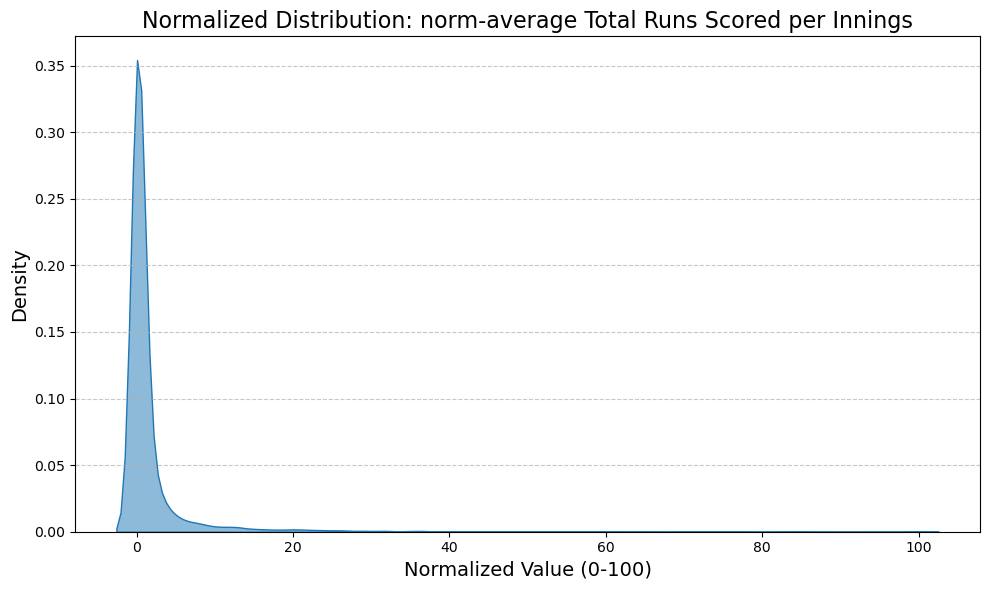

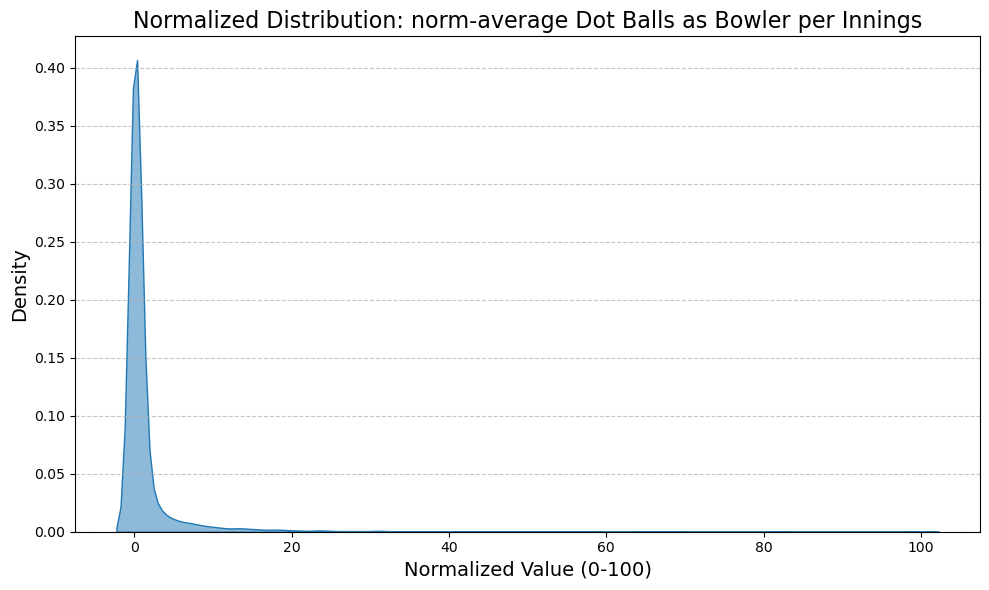

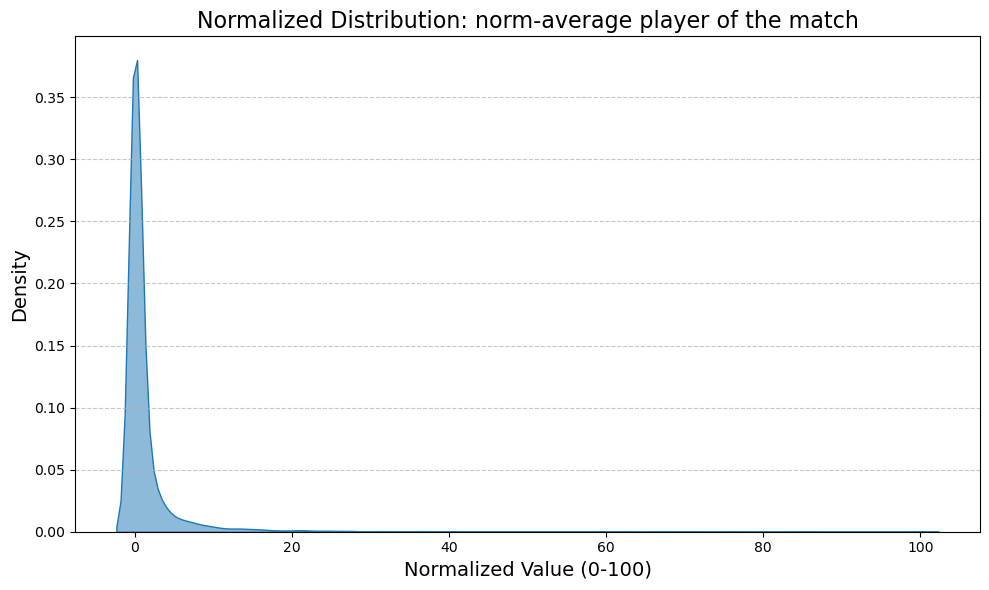

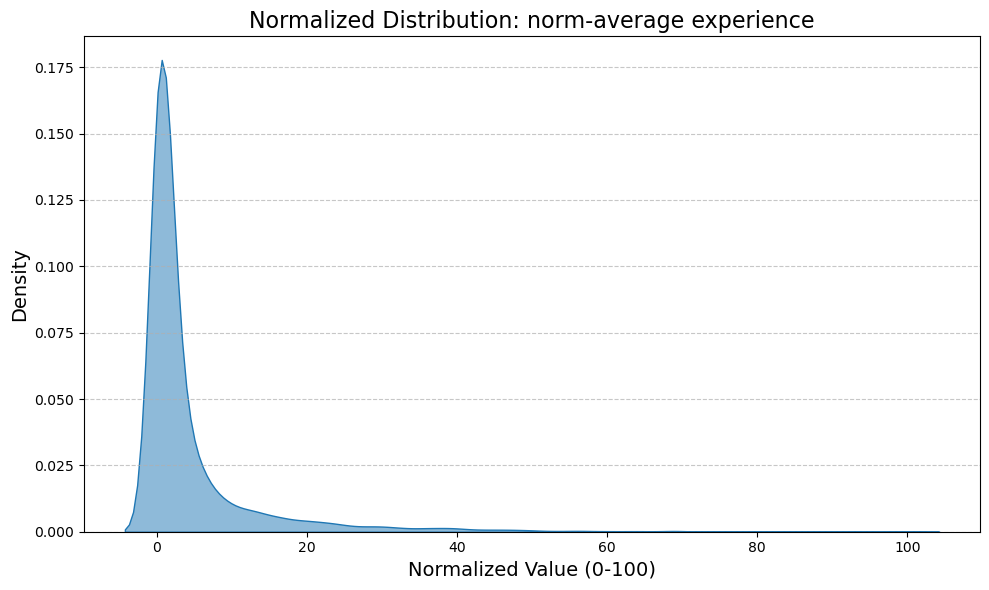

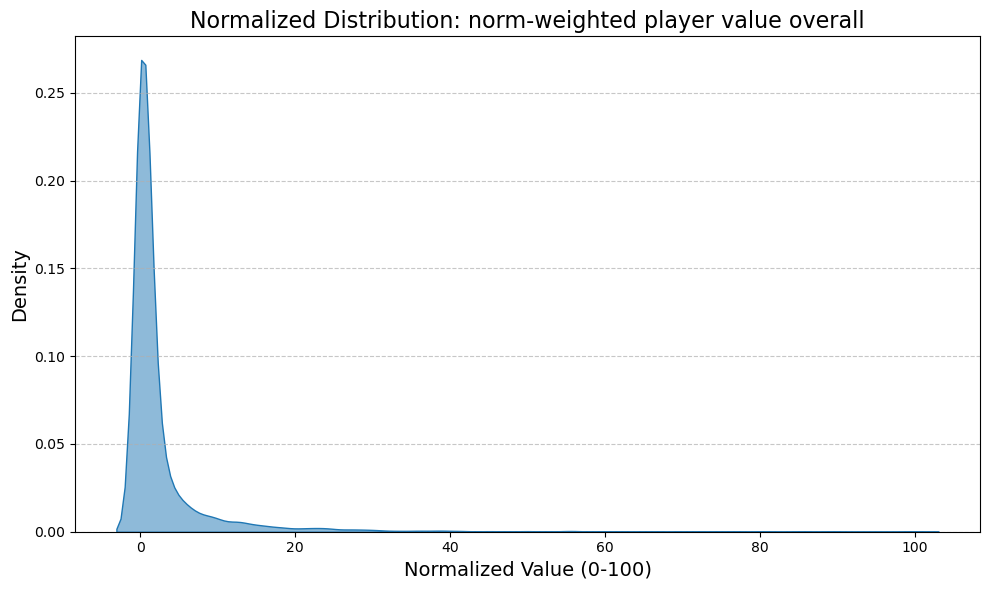

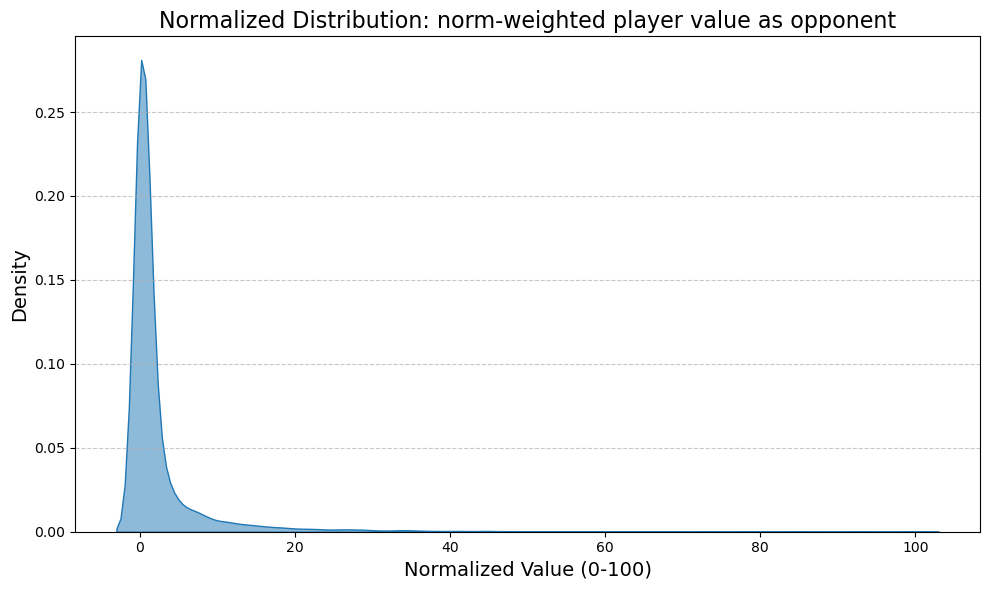

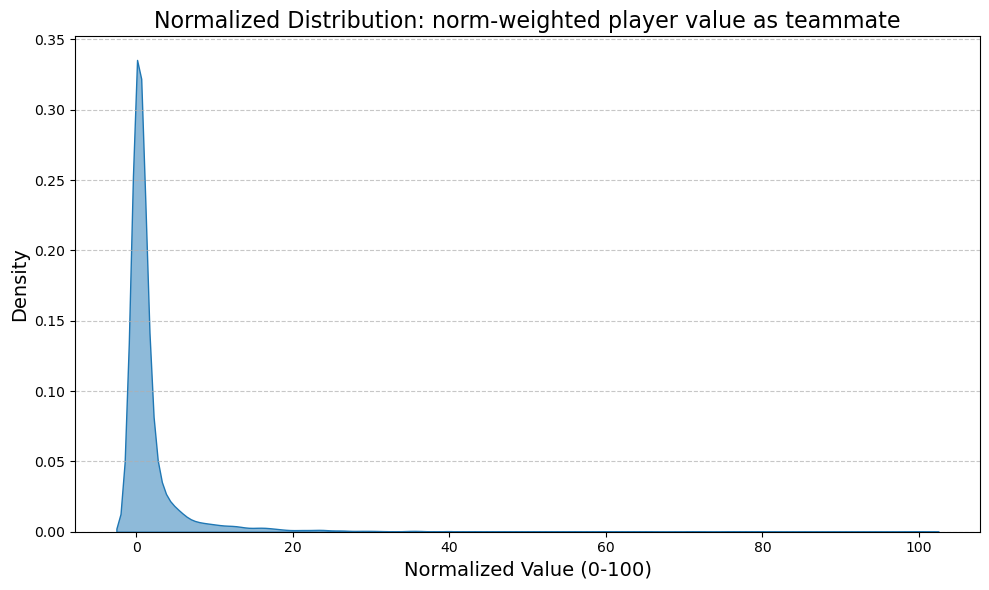

In [8]:
def plot_individual_metrics(df):
    # Define the metrics to plot based on the correctly named columns from data frame
    metrics = [
        'norm-average Total Runs Scored per Innings', 'norm-average Dot Balls as Bowler per Innings',
        'norm-average player of the match', 'norm-average experience',
        'norm-weighted player value overall', 'norm-weighted player value as opponent', 
        'norm-weighted player value as teammate'
    ]
    
    # Plot each metric separately
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=df, x=metric, fill=True, alpha=0.5)
        
        # labels and title
        plt.title(f'Normalized Distribution: {metric}', fontsize=16)
        plt.xlabel('Normalized Value (0-100)', fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Show the plot
        plt.tight_layout()
        plt.show()

# Usage:'today_normalized' contains the correct and curret data structure from normalization function
plot_individual_metrics(todaydata)

### Q1.1 top 10 best players of the the total runs

In [9]:
todaydata[['Player','norm-average Total Runs Scored per Innings']].sort_values(by='norm-average Total Runs Scored per Innings',ascending=False).head(10)

,Player,norm-average Total Runs Scored per Innings
10530,V Kohli,100.000000
5023,KC Sangakkara,84.114632
8141,RG Sharma,77.037779
420,AB de Villiers,74.782046
2456,DA Warner,72.604134
2035,CH Gayle,70.033305
6399,MS Dhoni,64.904165
7837,Q de Kock,60.895001
3648,HM Amla,60.059645
5669,LRPL Taylor,59.402244


### Q1.2 best players of the total dot balls

In [10]:
todaydata[['Player','norm-average Dot Balls as Bowler per Innings']].sort_values(by='norm-average Dot Balls as Bowler per Innings',ascending=False).head(10)

,Player,norm-average Dot Balls as Bowler per Innings
4527,JM Anderson,100.000000
9044,SCJ Broad,81.953837
7867,R Ashwin,68.271264
7086,NM Lyon,67.738515
4660,JS Patel,66.637458
10167,TG Southee,65.393530
7674,PM Siddle,56.955266
9649,Shakib Al Hasan,56.623805
8073,RA Jadeja,55.461155
2667,DW Steyn,55.062387


### Q1.3 best players of the  player of the match

In [11]:
todaydata[['Player','norm-weighted player value overall']].sort_values(by='norm-weighted player value overall',ascending=False).head(10)

,Player,norm-weighted player value overall
10530,V Kohli,100.000000
9649,Shakib Al Hasan,89.148540
2035,CH Gayle,85.302369
420,AB de Villiers,80.258250
8141,RG Sharma,76.683528
5023,KC Sangakkara,74.734722
9301,SR Watson,71.436239
2456,DA Warner,70.182266
7837,Q de Kock,66.206959
8073,RA Jadeja,65.727212


## Q1.1,2,3 :Result Analysis and Insight

This visualization demonstrates that some players significantly outperform others, making them highly effective in influencing match outcomes. From the graph, we can draw several key insights and address some considerations for machine learning applications:

### Key Observations:
1. **Player Strength Variability**:
   - The graph highlights the disparity in player strength. Some players are exceptionally impactful, while others contribute moderately.
   - This variability underscores the importance of considering overall team performance rather than individual brilliance alone.

2. **Team Contribution**:
   - Cricket is fundamentally a team game, and while individual performances matter, consistent team contributions drive victories.
   - Relying on one or two players, even if they are outstanding, may not guarantee success without support from the rest of the team.

### Implications for Machine Learning Applications:
1. **Summing Player Values for Team Strength**:
   - For machine learning modeling, it is more effective to aggregate player values (e.g., as a sum or average) to represent overall team strength.
   - This approach avoids overfitting to the influence of a single player and better reflects the collective effort needed for victories.

2. **Interchangeable Player Roles**:
   - In many cases, there is no significant difference between Player 1 and Player 2 in terms of their impact on the game. For modeling purposes:
     - Player positions should not be treated as unique factors since roles and contributions can be interchangeable.
     - For instance, swapping Player 1 and Player 2 in the dataset should not affect predictions.

3. **Team-Oriented Metrics**:
   - Machine learning models should emphasize team-level metrics rather than individual-level granularity. This avoids inaccuracies stemming from overemphasizing individual player statistics.

### Conclusion:
This graph not only highlights the importance of star players but also emphasizes the critical role of team dynamics. Machine learning applications should prioritize team-level features and ensure robust handling of player roles to accurately capture the essence of cricket as a team sport.


### Q:2 Which teams have the highest number of wins and ration of wins per games they plaied?

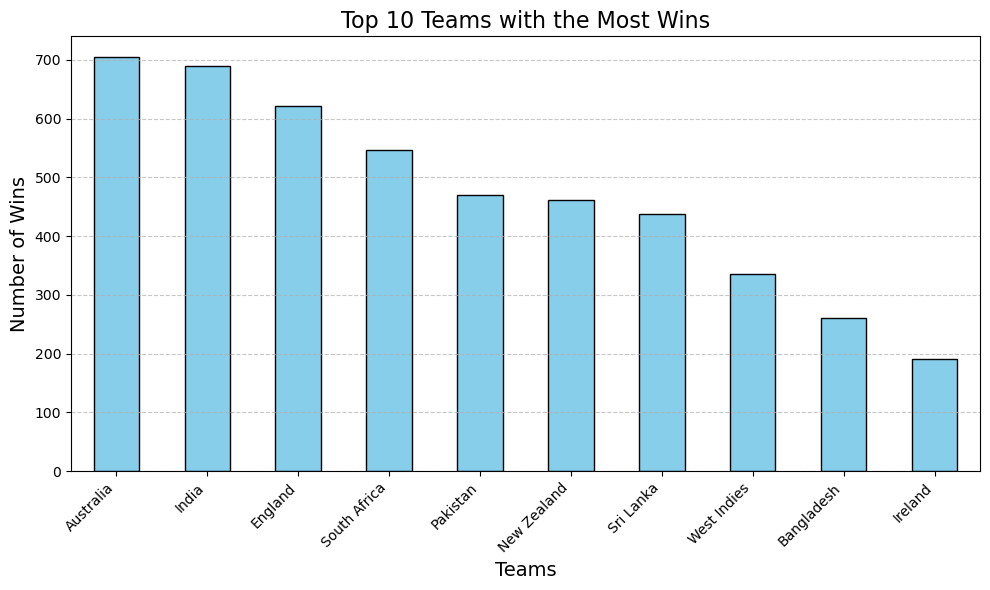

In [12]:
top_winners = teamAB['Winner'].value_counts().head(10)

# Plot the bar graph
plt.figure(figsize=(10, 6))
top_winners.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Teams with the Most Wins', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Number of Wins', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



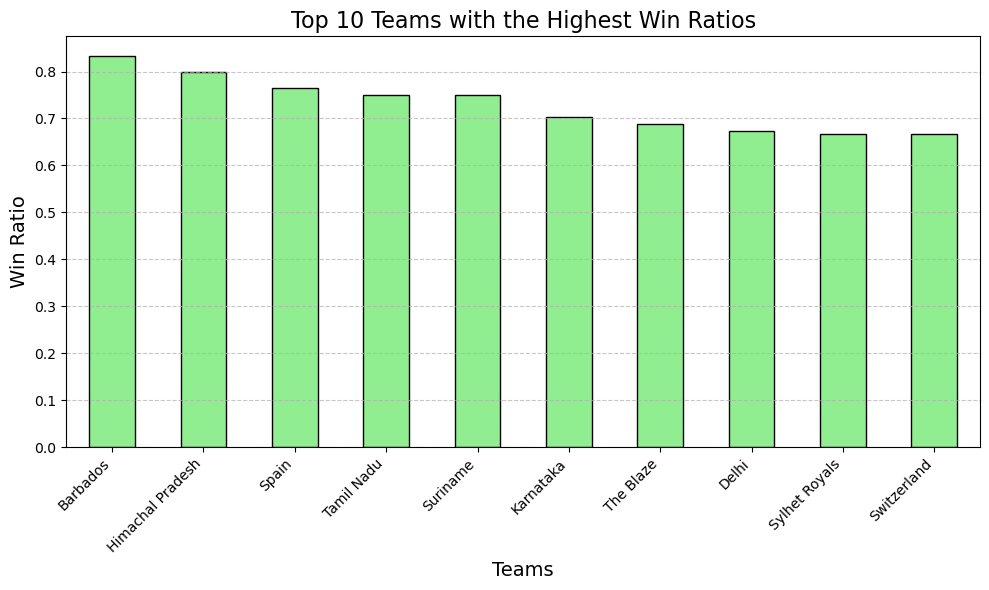

In [13]:
# Calculate the total games played for each team
total_games = teamAB['Team A'].value_counts() + teamAB['Team B'].value_counts()

# Calculate win ratios
win_ratios = (teamAB['Winner'].value_counts() / total_games).dropna()

# Select the top 10 teams with the highest win ratios
top_win_ratios = win_ratios.sort_values(ascending=False).head(10)

# Plot the bar graph for win ratios
plt.figure(figsize=(10, 6))
top_win_ratios.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Top 10 Teams with the Highest Win Ratios', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Win Ratio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


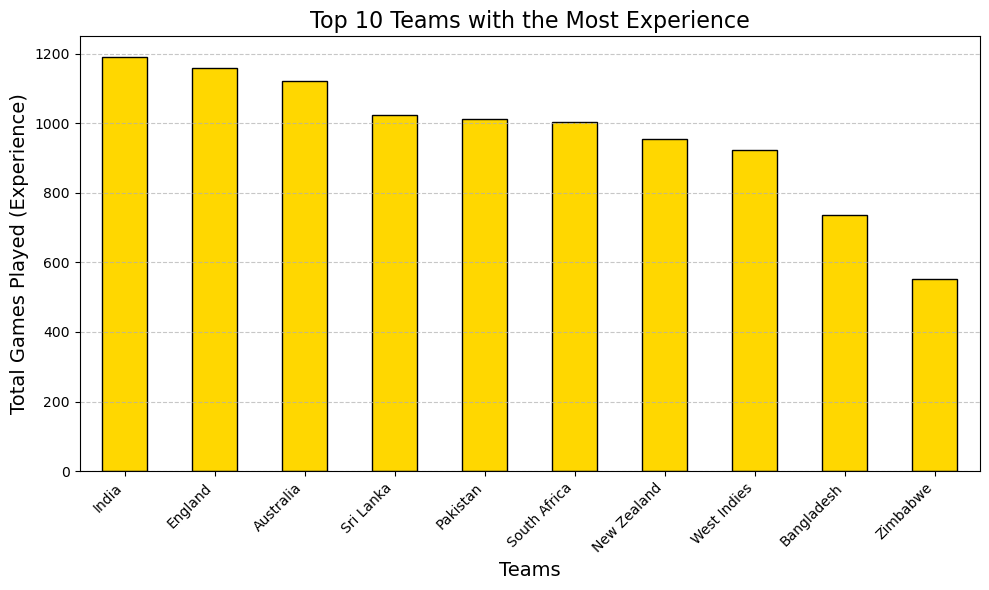

In [14]:
# Calculate the total games played for each team (experience)
team_experience = teamAB['Team A'].value_counts() + teamAB['Team B'].value_counts()

# Sort the teams by experience and select the top 10
top_experienced_teams = team_experience.sort_values(ascending=False).head(10)

# Plot the bar graph for team experience
plt.figure(figsize=(10, 6))
top_experienced_teams.plot(kind='bar', color='gold', edgecolor='black')
plt.title('Top 10 Teams with the Most Experience', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Total Games Played (Experience)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Q2: Analysis of Wins and Expeince by Teams

### Result Insight:
The analysis of team wins, experince and their ratio highlights that besides individual player performance, **team success** is equally crucial in determining match outcomes. A team's historical wins provide valuable insights into its legacy, strategy, and dominance in the sport.

### Key Observations:
1. **Historical Wins as a Factor**:
   - Teams with a high number of historical wins often demonstrate better preparation, tactics, and execution.
   - These wins serve as an indicator of a team's consistency and adaptability over time.

2. **Popularity and Strategic Acumen**:
   - The frequency of wins by certain teams can be tied to how popular the sport is in their respective countries. 
   - Teams from cricket-dominant nations tend to have a stronger support system, infrastructure, and deeper knowledge of game tactics.

### Implications for Analysis and Machine Learning:
1. **Incorporating Historical Wins**:
   - Historical wins can be used as a **feature** in predictive models to gauge a team's psychological advantage and momentum in upcoming matches.
   - This can help quantify the experience and reputation a team brings into a game.

2. **Country-Level Popularity**:
   - For teams, a factor representing how popular cricket is in their country can be added. Popularity influences:
     - Access to talent pools.
     - Fan support and morale.
     - Quality of coaching and infrastructure.

3. **Game Tactics and Preparation**:
   - Historical wins may also hint at the team's ability to analyze opponents, adapt strategies, and execute them effectively.
   - Capturing this in the data can reveal insights into team dynamics and planning.

### Conclusion:
The graph underscores that **team wins** go beyond individual brilliance and reflect the broader dynamics of strategy, preparation, and country-level cricket culture. Machine learning applications should incorporate team historical performance and external factors like popularity and strategy to improve predictive accuracy.


### Q3: Which player scored the most runs in a single game, and when?

In [15]:
players[players['Total Runs Scored']==players['Total Runs Scored'].max()] 

,Date,Player,Total Runs Scored,Dot Balls as Bowler,Player of the Match,Number of Innings
134354,2014-02-04,KC Sangakkara,424,0,1,4


### Q4: Which player bowled the most dot balls in a single game, and when?

In [16]:
players[players['Dot Balls as Bowler']==players['Dot Balls as Bowler'].max()] 

,Date,Player,Total Runs Scored,Dot Balls as Bowler,Player of the Match,Number of Innings
218977,2022-03-16,MJ Leach,4,492,0,4


### Q5:Which player has won the Player of the Match award the most?

In [17]:
players.groupby('Player')['Player of the Match'].sum().sort_values(ascending=False).head(1) 


Player
V Kohli    83
Name: Player of the Match, dtype: int64

### Q6:Which games had the highest scores and were the most exciting to watch?

In [18]:
top_matches = teamAB[['Date', 'Team A', 'Team B', 'Score Team A', 'Score Team B']].assign(
    Total_Score=teamAB['Score Team A'] + teamAB['Score Team B']
).sort_values(by='Total_Score', ascending=False).head(10)
top_matches 

,Date,Team A,Team B,Score Team A,Score Team B,Total_Score
14211,2022-12-01,England,Pakistan,921,847,1768
12248,2004-01-02,India,Australia,916,831,1747
3718,2006-01-21,Pakistan,India,1078,624,1702
10554,2022-06-10,New Zealand,England,837,838,1675
6950,2015-11-13,Australia,New Zealand,944,728,1672
4267,2009-02-26,West Indies,England,749,879,1628
5620,2013-03-08,Sri Lanka,Bangladesh,905,708,1613
12421,2023-04-06,Yorkshire,Leicestershire,803,807,1610
6404,2015-05-21,England,New Zealand,867,743,1610
4048,2007-12-08,India,Pakistan,910,699,1609


## Results for Q3, Q4, Q5, and Q6

### Key Observations:

### **Q3: Who scored the most runs in a single game, and when?**
- **Insight**: Some players show extraordinary performances in single games, breaking records unexpectedly. These outlier performances are valuable for understanding peak capabilities of players.
- **Impact on Modeling**:
  - Treat such events as **rare outliers** but ensure they do not dominate the overall model.


---

### **Q4: Who bowled the most dot balls in a single game, and when?**
- **Insight**: Similar to Q3, record-breaking performances in bowling (e.g., most dot balls) showcase the exceptional control and effectiveness of individual players.
- **Impact on Modeling**:
  - Bowling performance should complement batting statistics in player evaluations.
  - Use **dot-ball records** as an independent feature to highlight defensive strength, critical in game outcomes.

---

### **Q5: Who has been the best player the most times?**
- **Insight**: Players consistently winning "Player of the Match" awards underline their ability to influence game outcomes significantly.
- **Impact on Modeling**:
  - This feature is **highly correlated** with overall player value and can be weighted accordingly.
  - Use historical "Player of the Match" awards to evaluate player consistency and match-winning impact.

---

### **Q6: Which games have been the most exciting and enjoyable to watch?**
- **Insight**:
  - Games with close scores or unexpected outcomes (upset wins) are perceived as exciting.
  - High total scores also often correlate with greater entertainment value.
- **Impact on Modeling**:
  - Use **score differences** and **total scores** as features to measure match quality.


---

### General Observations:
1. **Record-breaking Performances**:
   - Extraordinary individual or team performances (high runs, dot balls, etc.) offer unique learning opportunities for models.
   - However, these should not disproportionately influence the overall feature set.

2. **Combining Features for Modeling**:
   - Aggregating performance metrics (e.g., team strength, historical wins, and player impact) helps balance the model.
   - Feature engineering should focus on categories like **game type**, **match dynamics**, and **extraordinary performances** to guide the model effectively.

3. **Game Type Categorization**:
   - Analyzing performance trends based on game type (e.g., ODI, T20, Test) allows the model to adapt to different formats.
   - Categorical features for game types can enhance the model's ability to generalize across varying match conditions.

### Conclusion:
By incorporating **extraordinary performances**, **feature aggregation**, and **game-type categorization**, predictive models can achieve a balance between recognizing outliers and understanding broader trends in cricket data. This approach ensures that record-breaking events and consistent team/player dynamics are both effectively captured.


### Q7: How do male and female teams compare in terms of performance across different match types?

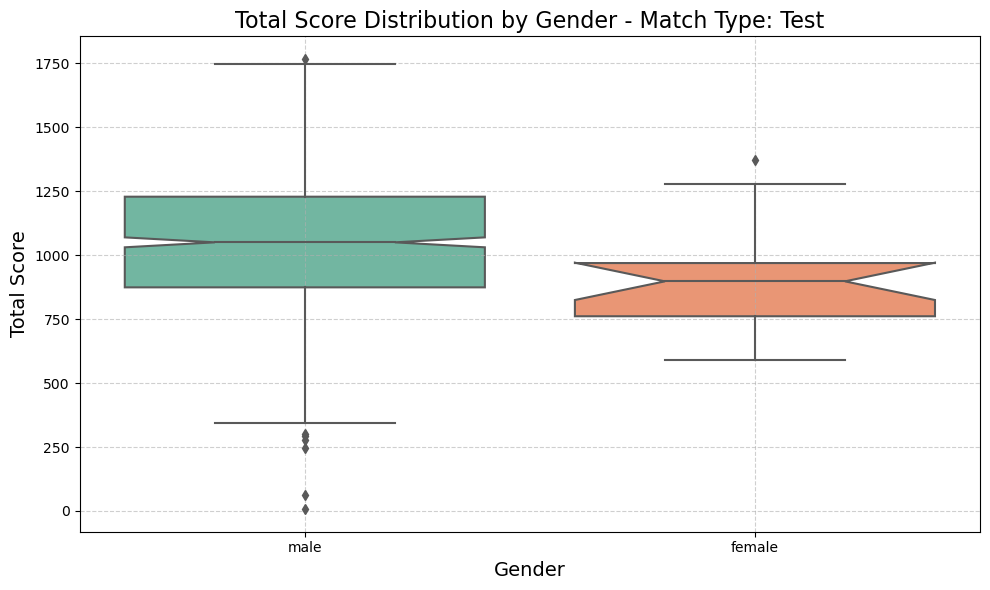

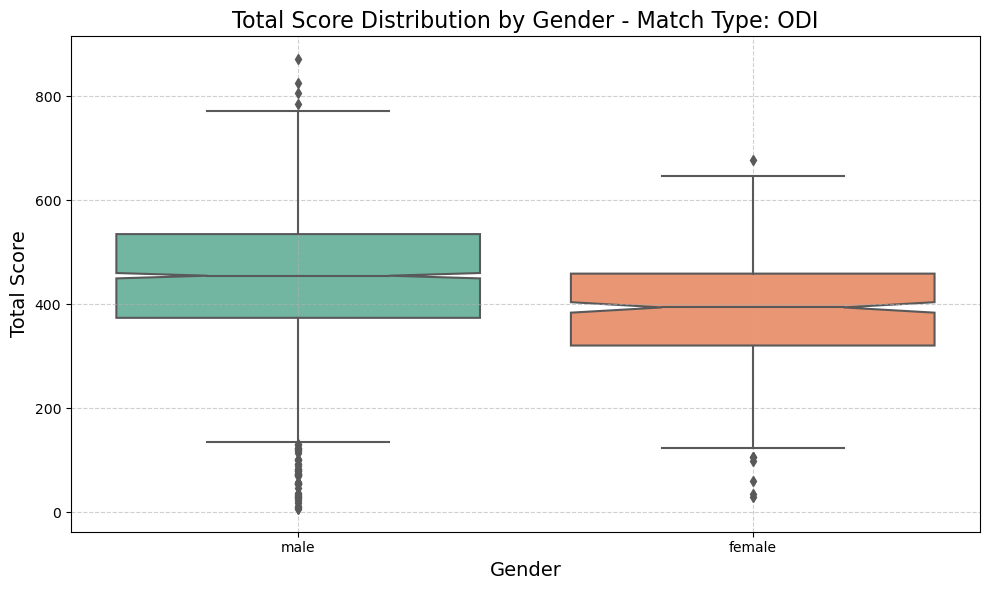

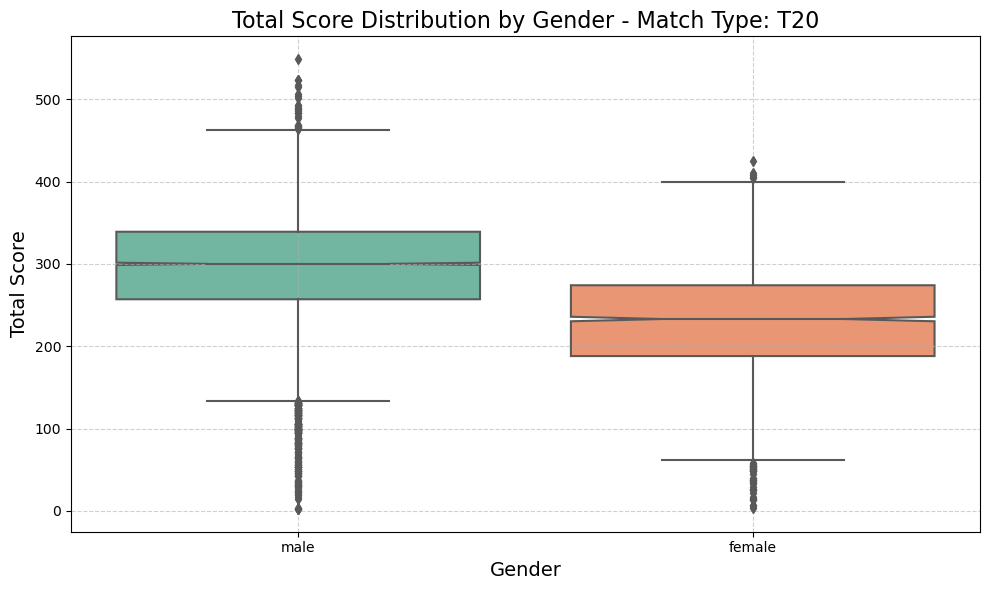

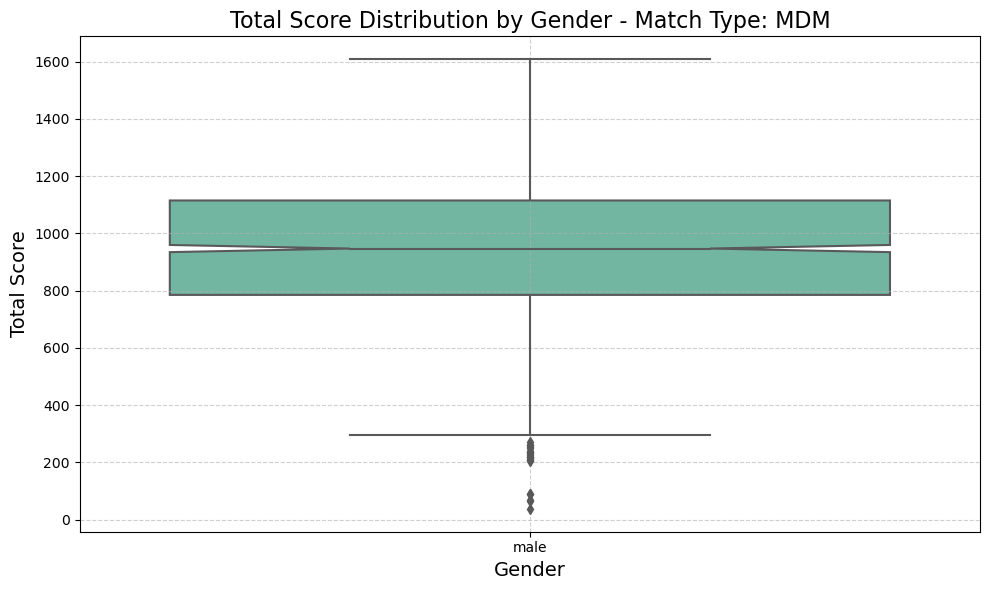

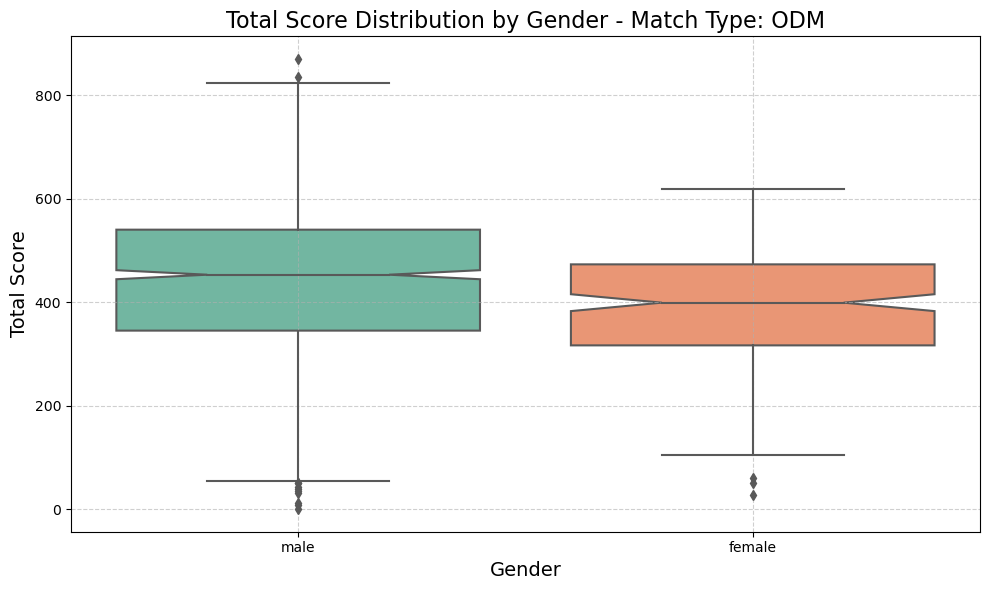

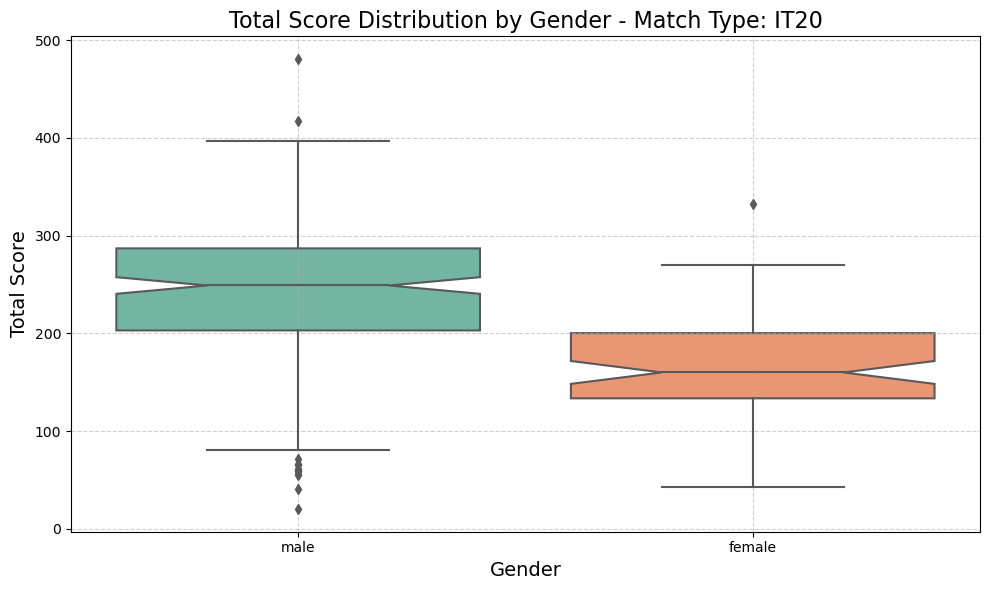

In [19]:
teamAB['Total_Score']=teamAB['Score Team A'] + teamAB['Score Team B']
# Loop through each match type and create a boxplot
for type_m in teamAB['Type'].unique():
    # Filter data for the current 'Type'
    filtered_data = teamAB[teamAB['Type'] == type_m]

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=filtered_data,
        x='Gender',
        y='Total_Score',
        palette='Set2',
        notch=True  # Optional: adds a notch for median confidence interval
    )
    
    # Add labels, title, and grid
    plt.title(f'Total Score Distribution by Gender - Match Type: {type_m}', fontsize=16)
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Total Score', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


### **Q7: Result**

### **Observation: Gender Comparison in Performance**

- **Insight**:
  - Despite efforts for gender equality in sports, the data reveals that, on average, men's games tend to have higher total scores compared to women's games.
  - This disparity is evident in both the mean and distribution of scores across various match types.
  - Men's performances generally exhibit higher variability and extreme values in scoring, while women's games show more consistency within a narrower range.

- **Impact on Modeling**:
  - **Gender as a Feature**:
    - Including gender as a categorical feature is crucial for understanding performance differences.
    - Models can leverage this distinction to better predict outcomes based on match type and gender-specific patterns.
  - **Normalization**:
    - Gender-based score normalization might be necessary to ensure fairness when evaluating mixed datasets.
  - **Factor Selection**:
    - Highlighting factors that significantly contribute to performance differences, such as team strength and game dynamics, allows the model to capture gender-specific trends effectively.

### **Conclusion:**
The results demonstrate that while gender differences in scoring are statistically significant, they should be interpreted carefully. Models should avoid bias by incorporating normalization techniques and focusing on gender-specific dynamics to ensure fair and accurate predictions.


### Q8:Has the quality and excitement of games dropped in the last 10 years?

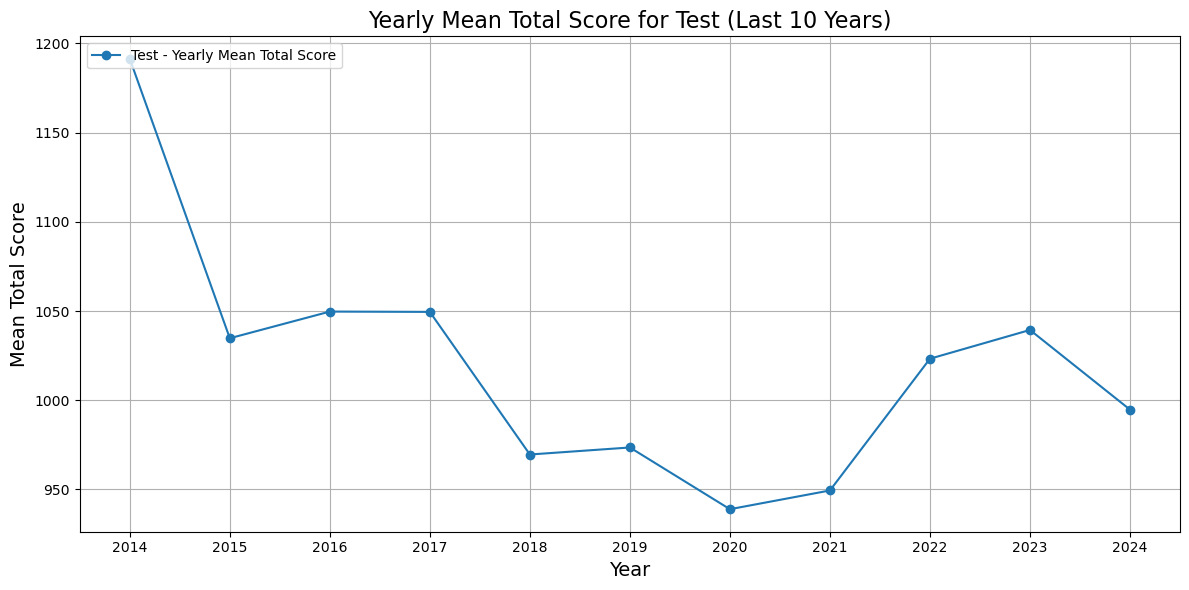

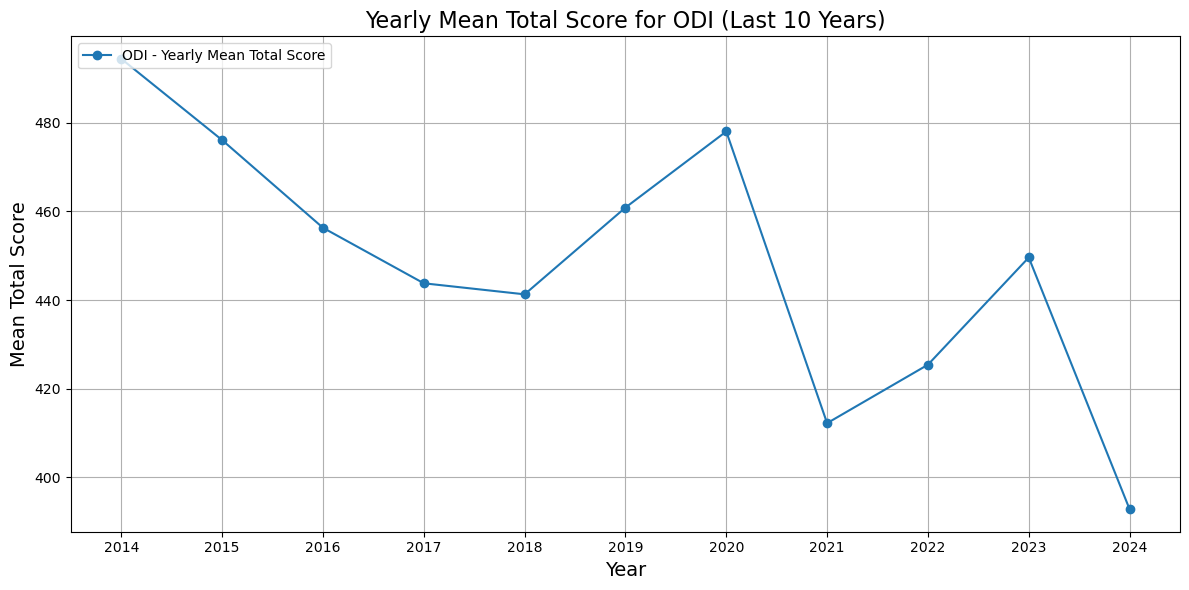

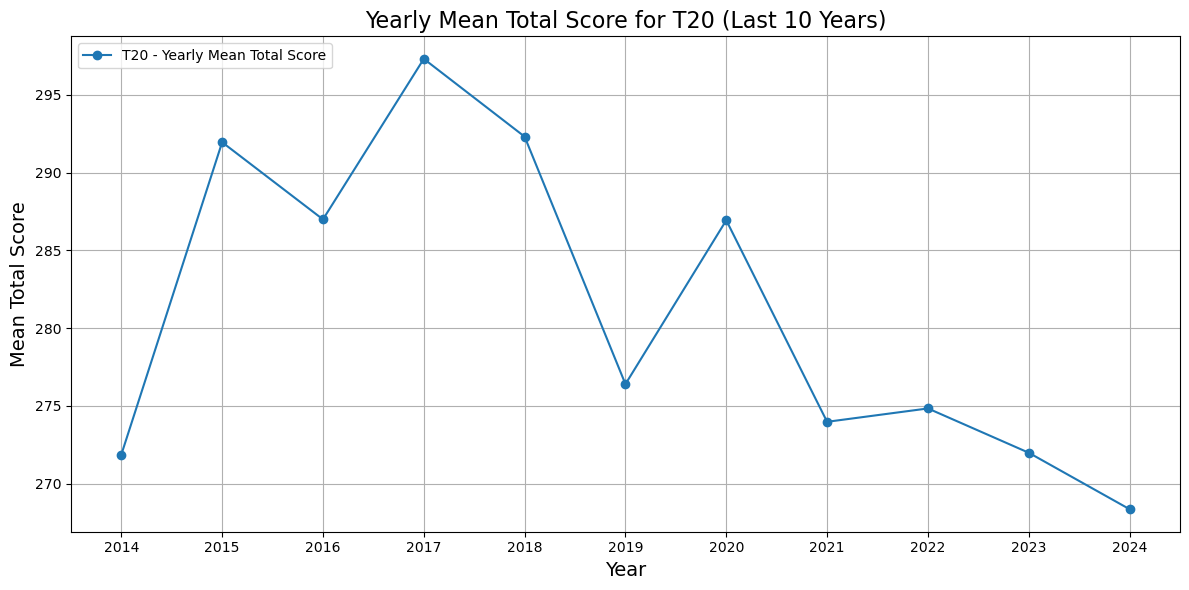

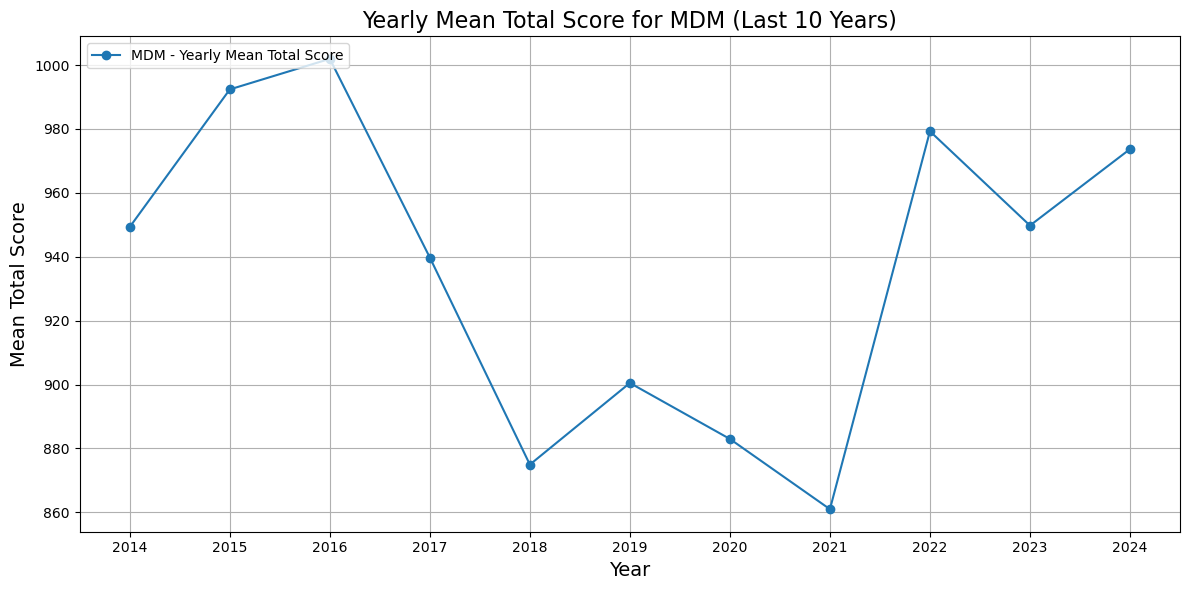

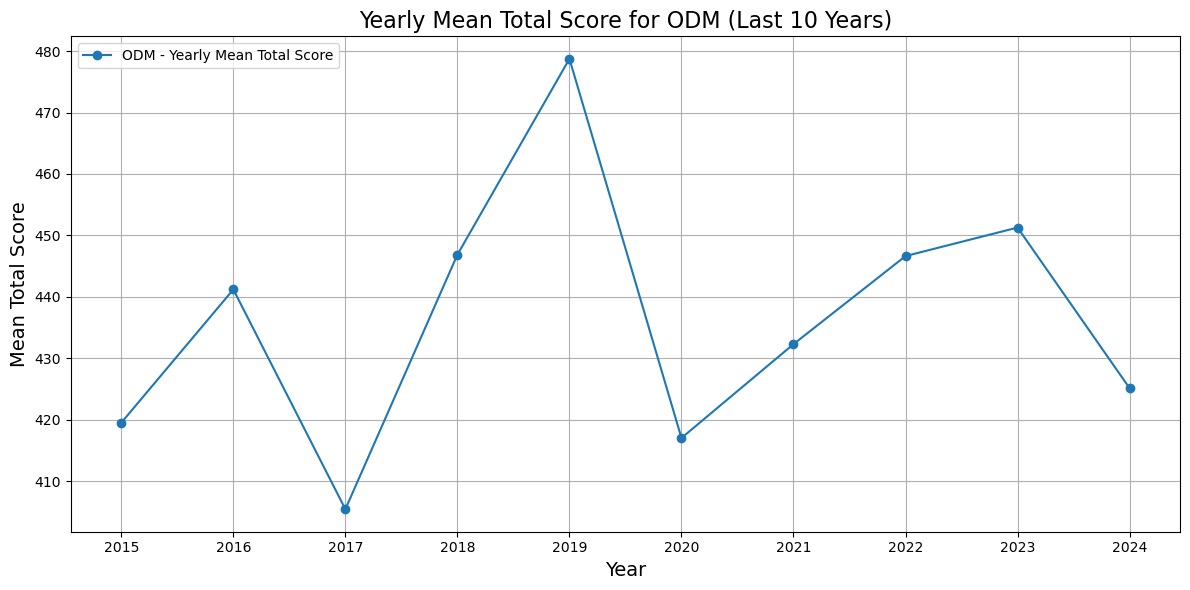

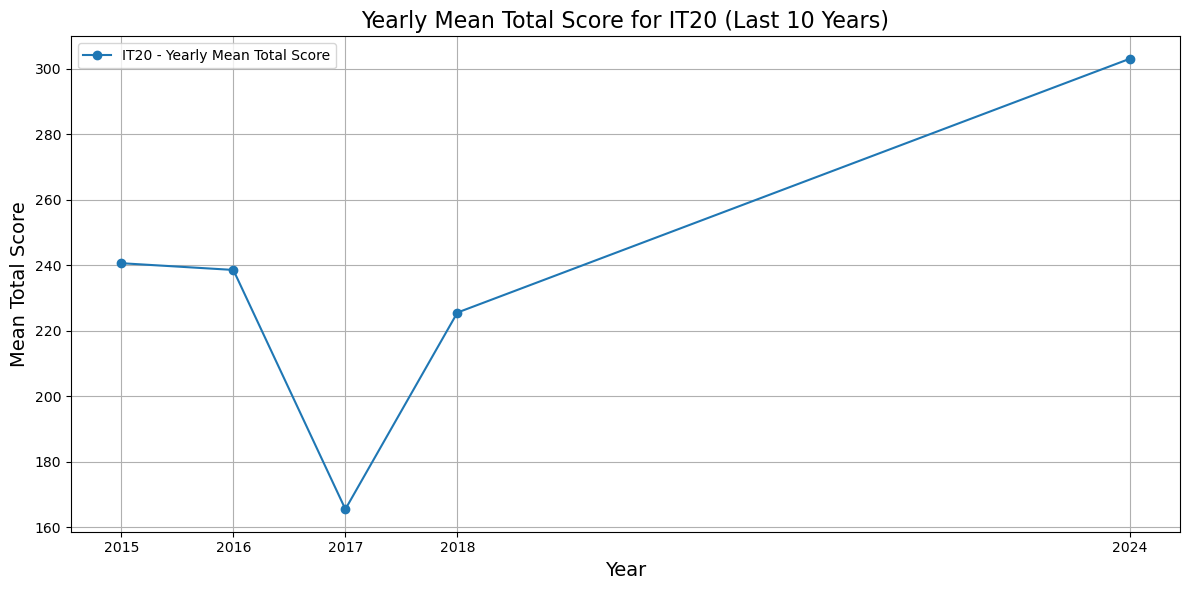

In [20]:


# Get the most recent date in the dataset
most_recent_date = teamAB['Date'].max()

# Calculate the cutoff date for the last 10 years
cutoff_date = most_recent_date - pd.DateOffset(years=10)

# Filter for the last 10 years
last_ten_years = teamAB[teamAB['Date'] >= cutoff_date]

# Create a new column for the total score
last_ten_years['Total_Score'] = last_ten_years['Score Team A'] + last_ten_years['Score Team B']

# Extract the year from the Date
last_ten_years['Year'] = last_ten_years['Date'].dt.year

# Unique types of matches
match_types = last_ten_years['Type'].unique()

# Plot the mean total scores for each match type
for match_type in match_types:
    plt.figure(figsize=(12, 6))
    
    # Filter data for the specific match type
    match_data = last_ten_years[last_ten_years['Type'] == match_type]
    
    # Calculate yearly mean total score
    yearly_mean = match_data.groupby('Year')['Total_Score'].mean().reset_index()
    
    # Plot the yearly mean total score
    plt.plot(
        yearly_mean['Year'], yearly_mean['Total_Score'], 
        label=f'{match_type} - Yearly Mean Total Score', marker='o', linestyle='-'
    )
    
    # Add labels, title, and legend
    plt.title(f'Yearly Mean Total Score for {match_type} (Last 10 Years)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Mean Total Score', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xticks(yearly_mean['Year'])
    plt.tight_layout()
    
    # Show the plot
    plt.show()


### **Q8: Result**

### **Observation: Trends in Game Quality Over the Last 5 Years**

- **Insight**:
  - **Overall Trend**:
    - The data indicates a general decline in game quality for ODI, Test, and T20 formats, as reflected by lower scores in recent years.
    - However, the trend is not consistent, with **fluctuations and drastic changes** observed across match types.
    - This suggests that while some games fall short of expectations, there is still the potential for high-scoring, exciting matches to attract audiences.

  - **Game Potential**:
    - The presence of some high-quality games amidst the decline shows that the formats have not entirely lost their appeal.
    - Strategic changes in game formats or player performance improvements could help reverse the declining trend.

- **Impact on Modeling**:
  - **Seasonal Analysis**:
    - Seasonal  fluctuations need to be captured to predict match quality more accurately.
    - Identifying patterns during specific years or tournaments could uncover factors influencing game quality.
  - **Audience Retention Factors**:
    - Insights about how high-scoring, exciting matches attract audiences can inform strategies to revitalize game formats.
    - Including features like historical match quality trends, player dynamics, and external factors (e.g., venues, weather) could improve model predictions.

### **Conclusion:**
While the quality of some matches has shown a decline in recent years, the variability and occasional resurgence of high-quality games highlight opportunities to revive audience interest. The data emphasizes the potential of ODI, Test, and T20 formats to remain engaging if key factors influencing game quality are addressed.


### Q9: Which type of match is the most popular for each gender?

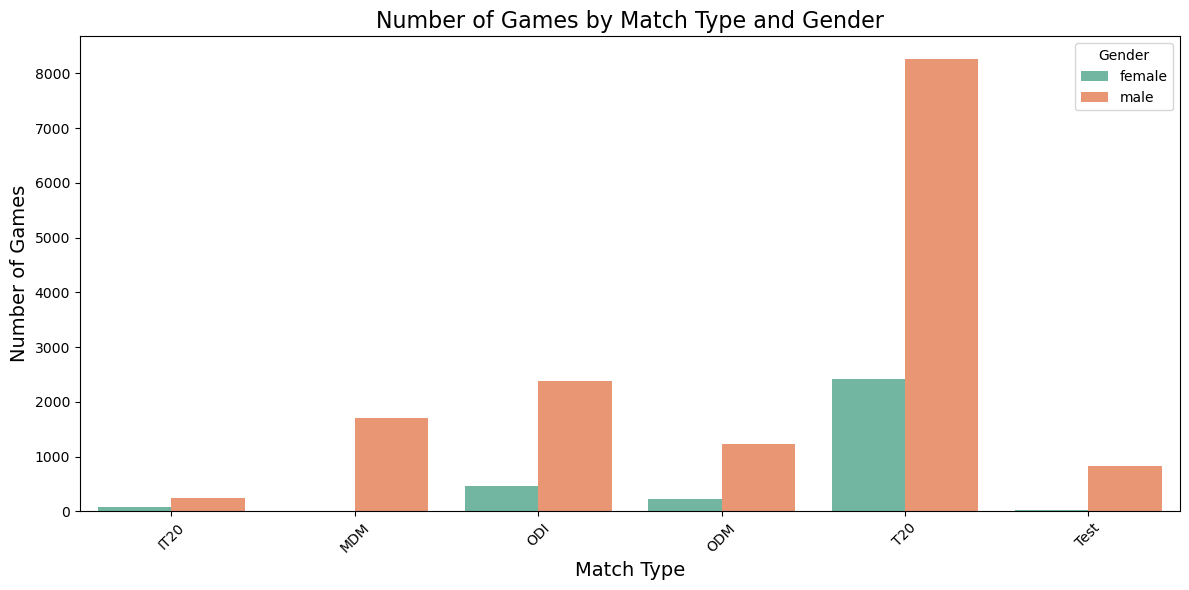

In [21]:

# Count the number of games for each type and gender
game_counts = teamAB.groupby(['Type', 'Gender']).size().reset_index(name='Number of Games')

# Plot bar graph
plt.figure(figsize=(12, 6))
sns.barplot(data=game_counts, x='Type', y='Number of Games', hue='Gender', palette='Set2')

# Add labels, title, and legend
plt.title('Number of Games by Match Type and Gender', fontsize=16)
plt.xlabel('Match Type', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()




### **Q9: Result**

### **Observation: Popularity of Game Types by Gender**

- **Key Insights**:
  - **Most Popular Type**:
    - **T20** is the most popular game type for both genders, indicating its widespread appeal across audiences.
  - **Least Popular Type**:
    - **IT20 (International T20)** appears to be the least popular, highlighting a gap in engagement for this format.
  
- **Gender-Based Trends**:
  - While **T20** leads in popularity for both genders, the data suggests potential differences in the level of interest and participation in other formats (e.g., ODI or Test matches).
  - Such differences could inform targeted strategies to enhance engagement for specific audiences.

- **Impact on Feature Engineering for ML Models**:
  - The popularity of game types is a crucial feature to consider for predictive modeling, as it directly influences audience retention, player motivation, and match outcomes.
  - Attention to **gender-based preferences** and their impact on game dynamics ensures a more nuanced approach to model design.
  - Incorporating detailed categorizations, such as gender-specific trends, match formats, and popularity metrics, can improve the accuracy of predictions.

### **Conclusion:**
The analysis emphasizes the dominance of **T20** as the most followed and popular game type across genders, highlighting its role as a critical feature in ML modeling. The results also underscore the importance of carefully engineered features and detailed analysis to better understand game dynamics and audience engagement.


### Q10: Which type of match is the most exciting to watch, and which games are closely followed?

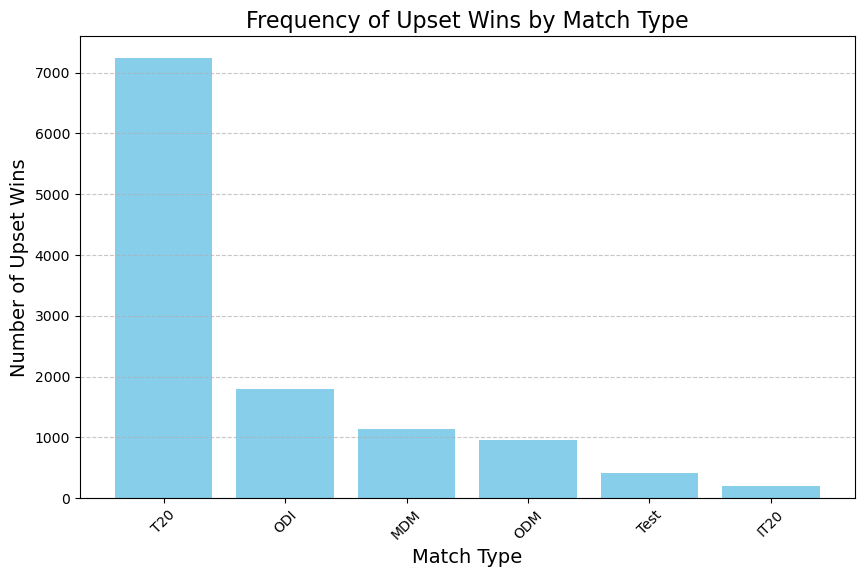

In [22]:

# Calculate score difference and identify upset wins
teamAB['Winning Team Score'] = teamAB.apply(
    lambda row: row['Score Team A'] if row['Winner'] == row['Team A'] else row['Score Team B'], axis=1)
teamAB['Losing Team Score'] = teamAB.apply(
    lambda row: row['Score Team B'] if row['Winner'] == row['Team A'] else row['Score Team A'], axis=1)

# Define upset wins where losing score is at least 90% of winning score
teamAB['Upset Win'] = teamAB['Losing Team Score'] >= 0.9 * teamAB['Winning Team Score']

# Filter upset wins
upset_wins = teamAB[teamAB['Upset Win']]

# --- Plot 1: Frequency of Upset Wins by Match Type ---
plt.figure(figsize=(10, 6))
upset_win_counts = upset_wins['Type'].value_counts()
plt.bar(upset_win_counts.index, upset_win_counts.values, color='skyblue')
plt.title('Frequency of Upset Wins by Match Type', fontsize=16)
plt.xlabel('Match Type', fontsize=14)
plt.ylabel('Number of Upset Wins', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

 


### **Q10: Excitement Levels and Thrill in Game Types**

### ** Observation: **

- **Key Insights**:
  - **T20 Matches**:
    - T20 games exhibit the highest total scores and closest margins, making them appear more thrilling and exciting to watch.
    - The high-paced nature of T20 matches and frequent shifts in momentum contribute to their appeal.
  - **Other Formats**:
    - While formats like Test and ODI show a different scoring pattern, their excitement is often derived from strategic depth rather than sheer scoring numbers.

- **Impact on Audience Engagement**:
  - The thrill of close, high-scoring games, especially in T20s, explains their popularity among spectators.
  - This highlights the importance of balancing excitement with strategy in other formats to maintain viewer interest.

- **Relevance to ML Modeling**:
  - Incorporating metrics like **score margins**, **total scores**, and **match formats** as features can help in predicting game outcomes and audience engagement.
  - Understanding the correlation between excitement levels and game formats can guide decisions for league organizers, broadcasters, and sponsors.

### **Conclusion:**
The analysis confirms that **T20** matches are the most thrilling and exciting format, underscoring their potential to attract and retain larger audiences. This insight is critical for crafting strategies to promote other formats and ensuring a well-rounded approach to game scheduling and marketing.
